In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from aif360.datasets import StandardDataset
from aif360.metrics import DatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric



In [313]:
data = pd.read_csv('../bank-additional/bank-additional-full.csv', sep=';' )

In [314]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [315]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [316]:
data['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [317]:
#Drop duration because of leakage explained in dataset website.
data = data.drop(labels=['duration'], axis=1)


In [318]:
len(data['age'].unique())

78

(array([3.300e+01, 4.200e+01, 6.500e+01, 1.020e+02, 1.370e+02, 2.260e+02,
        4.630e+02, 5.980e+02, 6.980e+02, 8.510e+02, 1.001e+03, 1.453e+03,
        1.714e+03, 1.947e+03, 1.846e+03, 1.833e+03, 1.745e+03, 1.759e+03,
        1.780e+03, 1.475e+03, 1.407e+03, 1.432e+03, 1.161e+03, 1.278e+03,
        1.142e+03, 1.055e+03, 2.114e+03, 1.030e+03, 9.280e+02, 9.790e+02,
        8.390e+02, 8.750e+02, 7.540e+02, 7.790e+02, 7.330e+02, 6.840e+02,
        6.480e+02, 7.040e+02, 6.460e+02, 5.760e+02, 4.630e+02, 2.830e+02,
        7.300e+01, 6.200e+01, 5.500e+01, 5.700e+01, 4.400e+01, 5.700e+01,
        2.600e+01, 3.300e+01, 3.400e+01, 4.700e+01, 8.700e+01, 3.400e+01,
        3.200e+01, 2.400e+01, 3.400e+01, 2.000e+01, 2.700e+01, 1.400e+01,
        3.100e+01, 2.000e+01, 1.700e+01, 1.700e+01, 7.000e+00, 1.500e+01,
        8.000e+00, 1.000e+00, 2.200e+01, 2.000e+00, 0.000e+00, 2.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([17.        , 18.03846154, 19

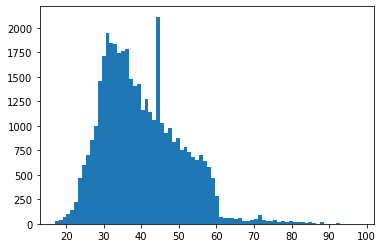

In [319]:
plt.hist(data['age'], bins=78)

In [320]:
data['y'] = data['y'].transform(lambda x: 1 if x == 'yes' else 0)

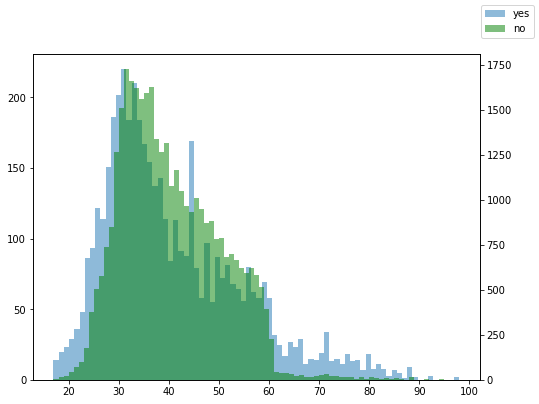

In [321]:
yes_data = data[data['y']==1]

no_data = data[data['y']==0]

fig, ax = plt.subplots(figsize=(8,6))

ax.hist(yes_data['age'], bins=78, alpha=.5, label='yes')

ax2 = ax.twinx()
ax2.hist(no_data['age'], bins=78, alpha=.5, label='no', color='green')

fig.legend()


In [322]:
no_data['education'].value_counts() / len(no_data['education'])


university.degree      0.287239
high.school            0.232133
basic.9y               0.152457
professional.course    0.127175
basic.4y               0.102550
basic.6y               0.057568
unknown                0.040495
illiterate             0.000383
Name: education, dtype: float64

In [323]:
yes_data['education'].value_counts()/ len(yes_data['education'])

university.degree      0.359914
high.school            0.222198
professional.course    0.128233
basic.9y               0.101940
basic.4y               0.092241
unknown                0.054095
basic.6y               0.040517
illiterate             0.000862
Name: education, dtype: float64

In [324]:
data['education'] = data['education'].transform(lambda x: 1 if x =='university.degree' or x=='professional.course' else 0)

In [325]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,0,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,0,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,0,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,0,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,0,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [326]:
u = [{'education': 0}]
p = [{'education': 1}]

In [327]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [328]:
sd_ed = StandardDataset(df=data,   
                         label_name='y',
                         favorable_classes =[1],
                        protected_attribute_names=['education'], 
                         privileged_classes=[[1]],
                        categorical_features=['job', 'marital', 'default', 'housing', 'loan','contact', 'month', 'day_of_week', 'poutcome'])



In [329]:
df_ed = sd_age.convert_to_dataframe()

In [330]:
df_ed

(        age  education  campaign  pdays  previous  emp.var.rate  \
 0      56.0        0.0       1.0  999.0       0.0           1.1   
 1      57.0        0.0       1.0  999.0       0.0           1.1   
 2      37.0        0.0       1.0  999.0       0.0           1.1   
 3      40.0        0.0       1.0  999.0       0.0           1.1   
 4      56.0        0.0       1.0  999.0       0.0           1.1   
 ...     ...        ...       ...    ...       ...           ...   
 41183  73.0        0.0       1.0  999.0       0.0          -1.1   
 41184  46.0        0.0       1.0  999.0       0.0          -1.1   
 41185  56.0        1.0       2.0  999.0       0.0          -1.1   
 41186  44.0        0.0       1.0  999.0       0.0          -1.1   
 41187  74.0        0.0       3.0  999.0       1.0          -1.1   
 
        cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
 0              93.994          -36.4      4.857       5191.0  ...        0.0   
 1              93.9

In [331]:
#age
#bl_age = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_age[0], label_names=['y'],
 #                   protected_attribute_names=['age'])

In [332]:
bl_ed = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_ed[0], label_names=['y'],
              protected_attribute_names=['education'])

In [333]:
data_train, data_vt = bl_ed.split([0.7], shuffle=True)

In [334]:
data_val, data_test = data_vt.split([0.5], shuffle=True)

In [335]:
metric_train = BinaryLabelDatasetMetric(data_train, 
                            unprivileged_groups=u, 
                            privileged_groups=p)

In [336]:
metric_train.mean_difference()

-0.029962346618419164

In [337]:
metric_train.disparate_impact()

0.7749535774182827

## Random Forest Classifer 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split